In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

In [ ]:
# Define the number of samples
n_samples = 5000  

# Set a random seed for reproducibility
np.random.seed(42)

# Generate random variables simulating operational conditions
temperatura = np.random.normal(loc=80, scale=10, size=n_samples)  # Mean 80°C, std 10°C
pressao = np.random.normal(loc=200, scale=30, size=n_samples)  # Mean 200 kPa, std 30 kPa
vibracao = np.random.normal(loc=5, scale=1.5, size=n_samples)  # Mean 5 mm/s, std 1.5 mm/s
horas_uso = np.random.randint(100, 10000, size=n_samples)  # Between 100 and 10,000 hours
tensao_mecanica = np.random.normal(loc=50, scale=15, size=n_samples)  # Mean 50 MPa, std 15 MPa
material = np.random.choice(['Titanium', 'Aluminum', 'Composite'], size=n_samples)  # Material type

# Define the target variable (failure: 1 = occurred, 0 = did not occur)
falha = (temperatura > 90) | (pressao > 250) | (vibracao > 7) | (horas_uso > 8000)
falha = falha.astype(int)  # Convert boolean to 0 or 1

# Create DataFrame
df = pd.DataFrame({
    'Temperature': temperatura,
    'Pressure': pressao,
    'Vibration': vibracao,
    'Usage_Hours': horas_uso,
    'Mechanical_Stress': tensao_mecanica,
    'Material': material,
    'Failure': falha
})

# Save as CSV file
df.to_csv('aerospace_failure_data.csv', index=False)

print("File generated: aerospace_failure_data.csv")

File generated: aerospace_failure_data.csv


First five rows of the dataset:
   Temperature    Pressure  Vibration  Usage_Hours  Mechanical_Stress  \
0    84.967142  187.287210   3.982258         1044          59.015103   
1    78.617357  186.397577   4.541751         5461          53.387434   
2    86.476885  146.130705   4.103928         9554          76.007434   
3    95.230299  190.097294   5.165627         5384          42.059628   
4    77.658466  221.984872   6.795768         6981          20.191837   

    Material  Failure  
0   Aluminum        0  
1   Titanium        0  
2  Composite        1  
3  Composite        1  
4  Composite        0  

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature        5000 non-null   float64
 1   Pressure           5000 non-null   float64
 2   Vibration          5000 non-null   float64
 3   Usage_Hours    

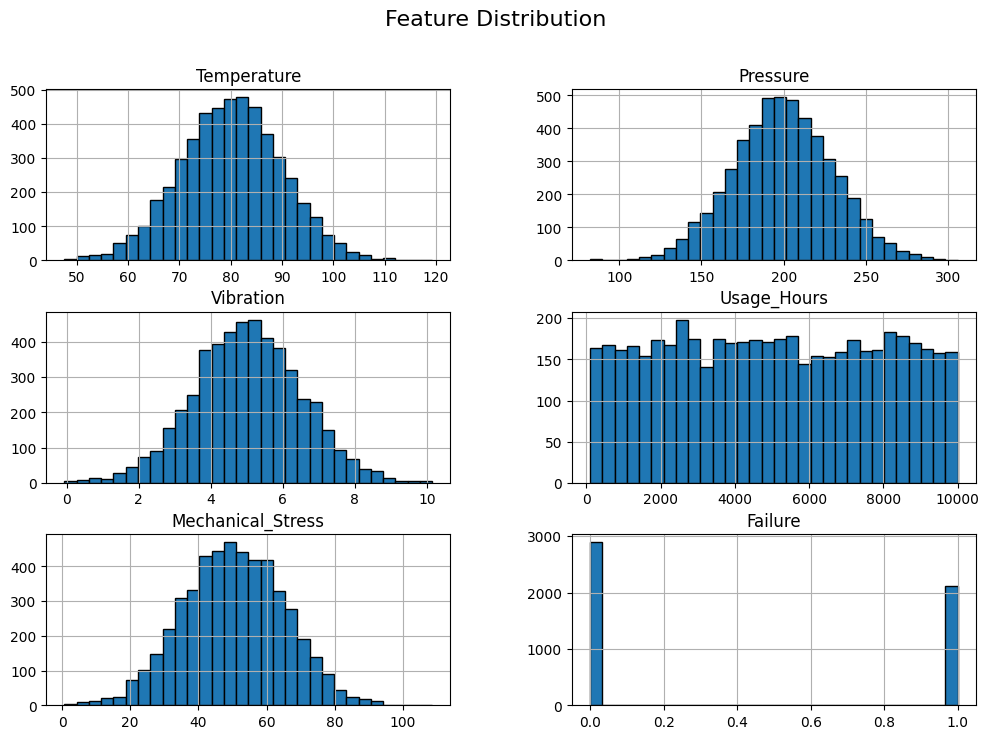

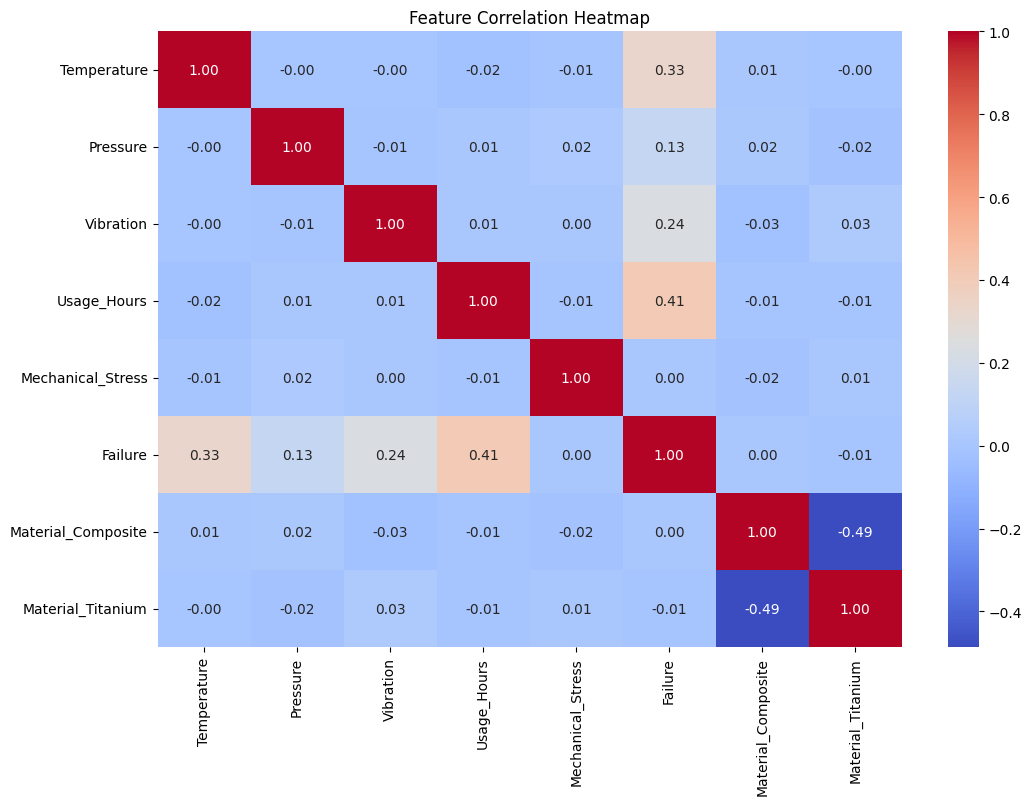

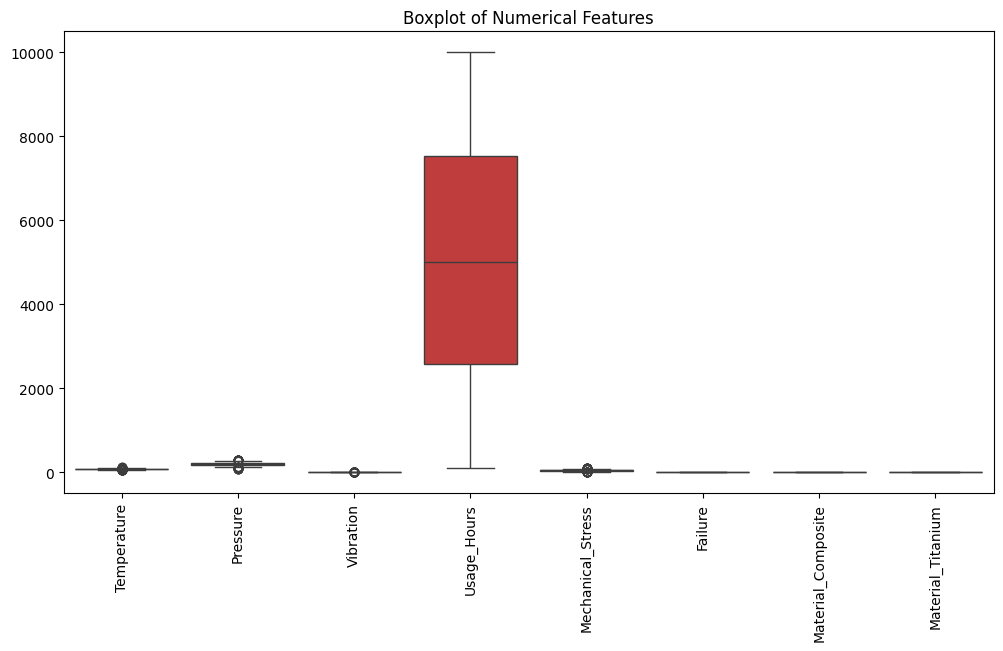

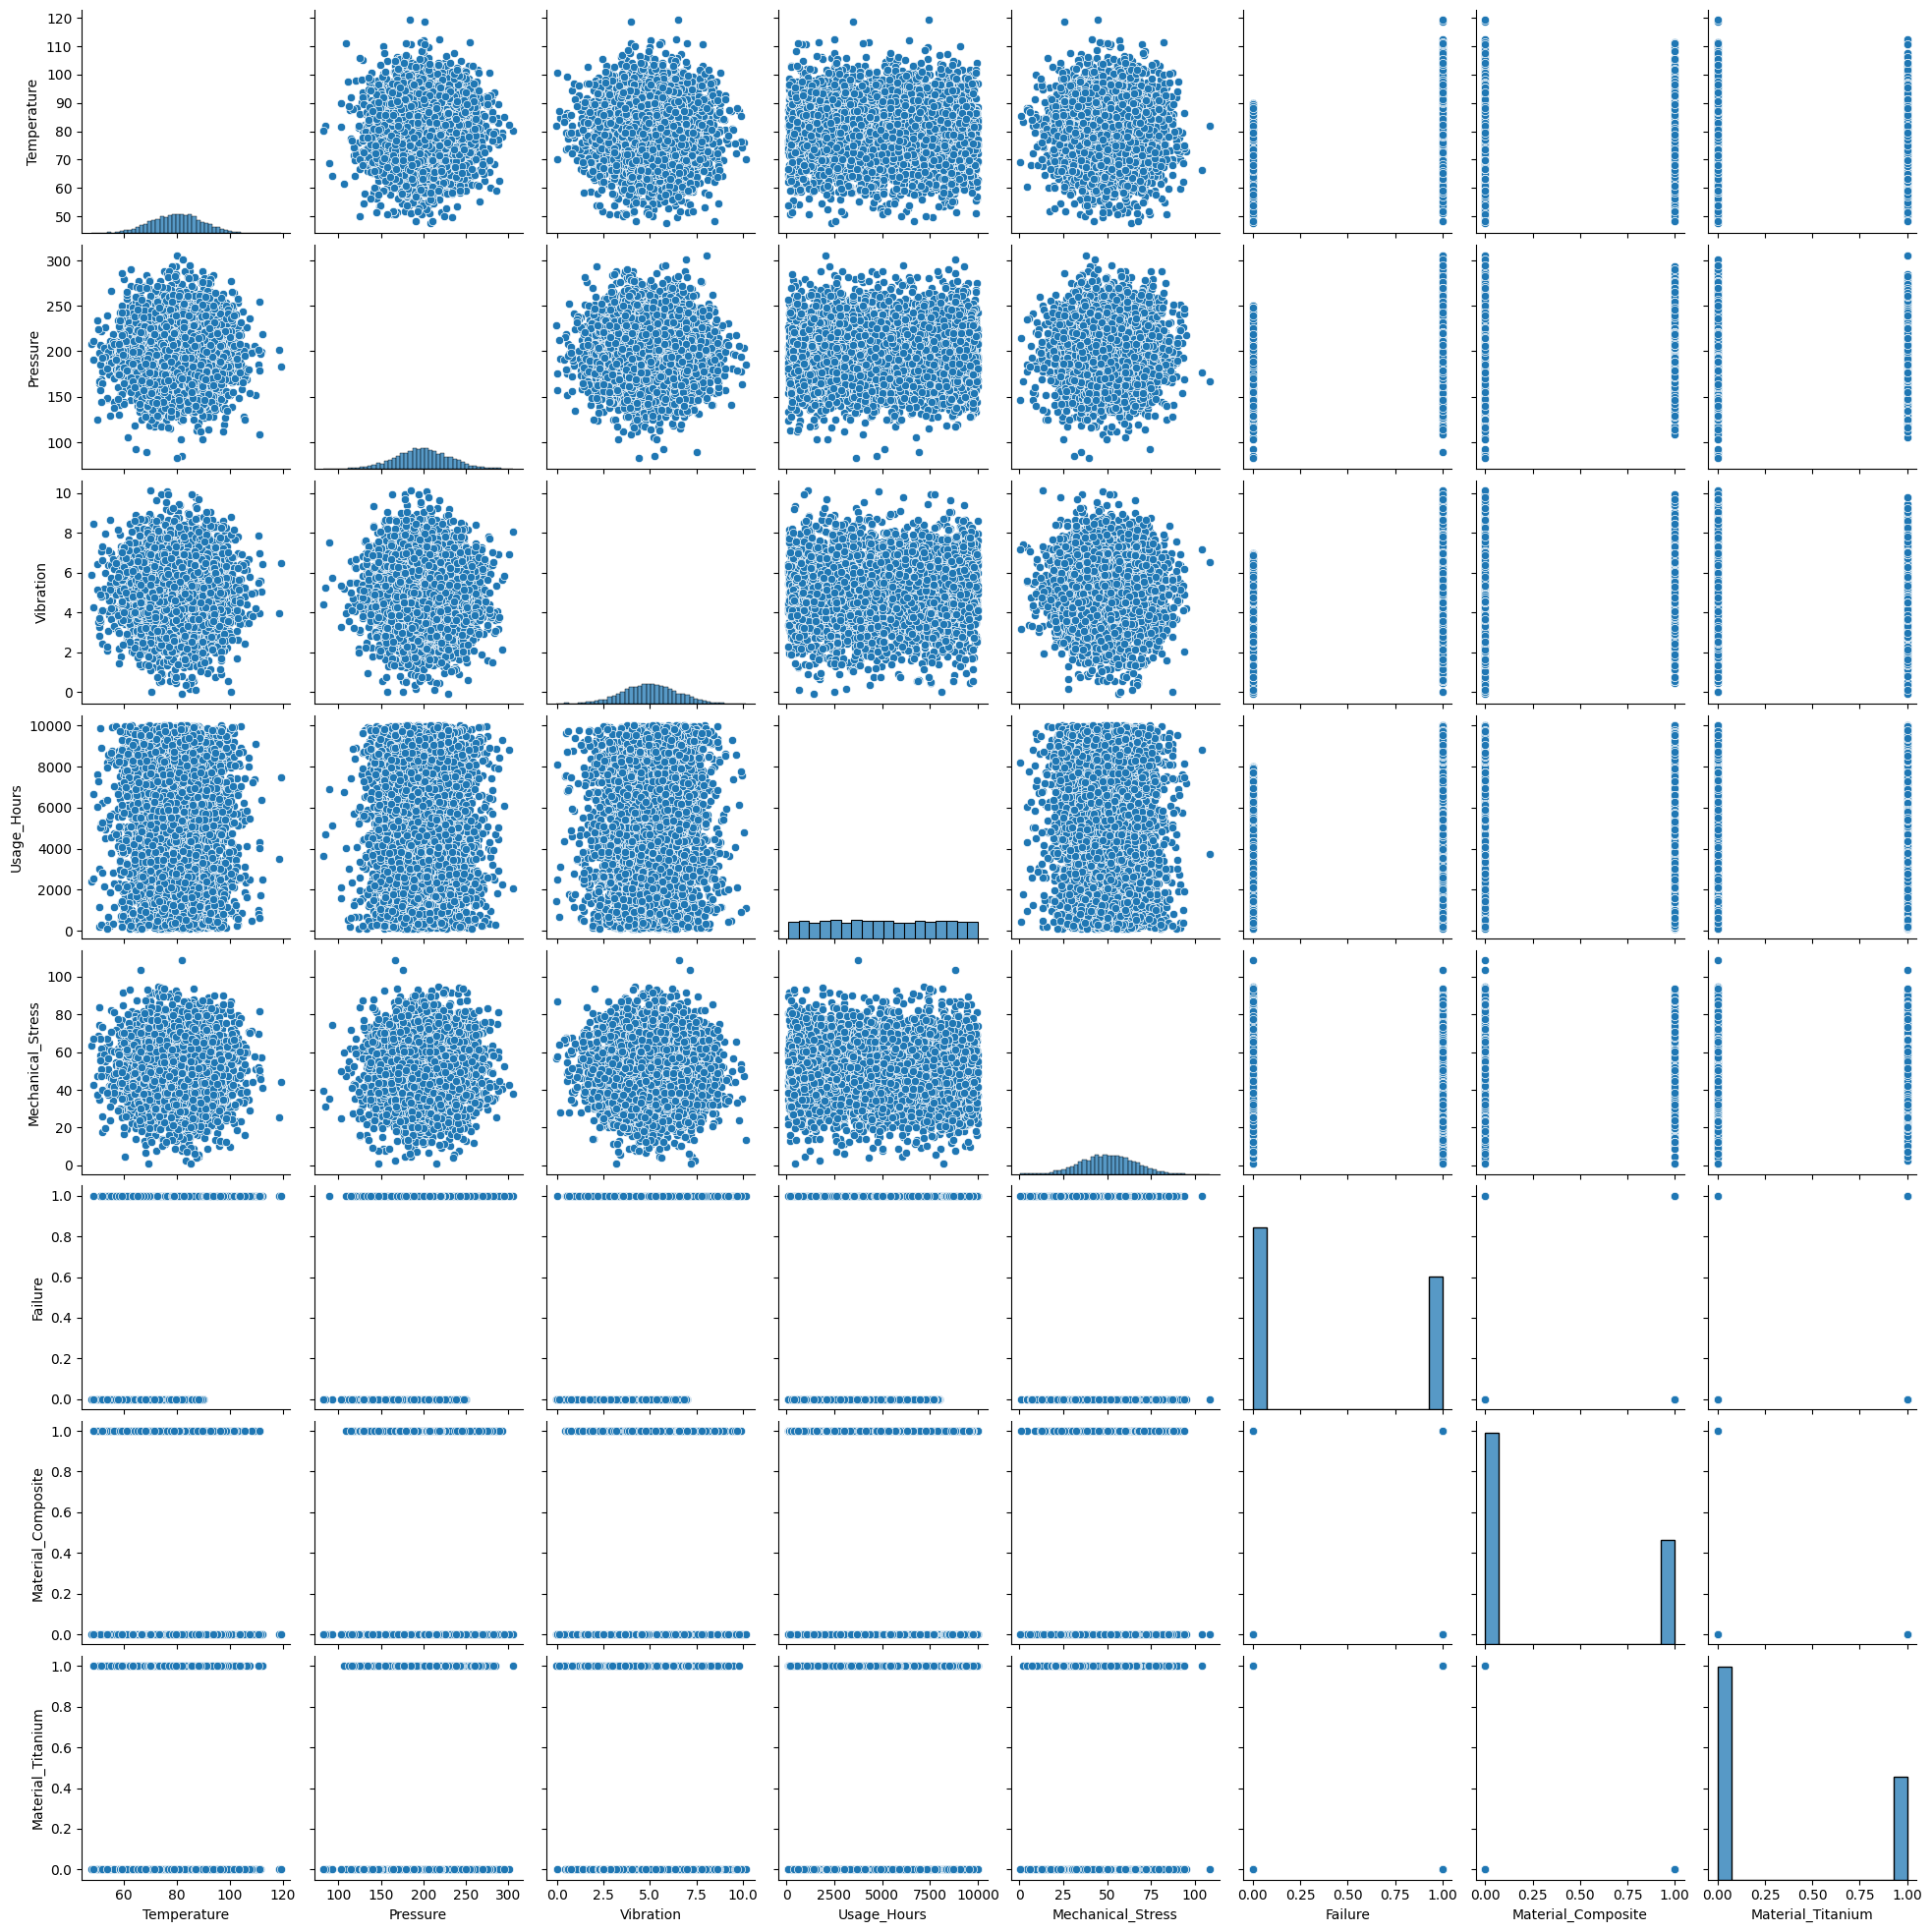

In [10]:
# Load dataset
df = pd.read_csv("aerospace_failure_data.csv")

# Display the first few rows
print("First five rows of the dataset:")
print(df.head())

# Basic information about the dataset
print("\nDataset Overview:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# One-Hot Encoding for categorical variables
df = pd.get_dummies(df, columns=["Material"], drop_first=True)

# Drop non-numeric columns that are not needed for correlation analysis
if "Component_ID" in df.columns:
    df.drop(columns=["Component_ID"], inplace=True)

# Summary statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

# Histograms for numerical features
df.hist(figsize=(12, 8), bins=30, edgecolor="black")
plt.suptitle("Feature Distribution", fontsize=16)
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Boxplots to check for outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.title("Boxplot of Numerical Features")
plt.show()

# Pairplot to visualize relationships between numerical features
sns.pairplot(df)
plt.show()


In [11]:
# Load dataset
df = pd.read_csv("aerospace_failure_data.csv")

# 1️⃣ Handling Categorical Data (One-Hot Encoding)
categorical_cols = ["Material"]  # Example categorical column
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 2️⃣ Feature Scaling (Standardization)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# 3️⃣ Creating New Features
# Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(df[numerical_cols])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(numerical_cols))
df = pd.concat([df, poly_df], axis=1)

# 4️⃣ Handling Outliers (IQR Method)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
df = df[~outlier_mask.any(axis=1)]

# 5️⃣ Feature Selection (Correlation & Importance)
# Removing highly correlated features
corr_matrix = df.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_cols = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9)]
df.drop(columns=drop_cols, inplace=True)

# Feature Importance using RandomForest
X = df.drop(columns=["Target"])  # Replace "Target" with actual target column
y = df["Target"]
model = RandomForestRegressor()
model.fit(X, y)
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Selecting top 10 important features
df = df[feature_importance.head(10).index]

# Save processed dataset
df.to_csv("aerospace_dataset_processed.csv", index=False)

print("Feature Engineering Completed. Processed dataset saved.")


FileNotFoundError: [Errno 2] No such file or directory: 'aerospace_dataset.csv'